In [1]:
import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap

from scipy.stats import spearmanr, pearsonr

from typing import Optional, Dict, Union
from torch.distributions import Bernoulli, Gamma, Poisson, Normal

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
scvi.set_seed(0)

In [3]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
import matplotlib.colors as mcolors
DPI = 300

In [4]:
anndataset = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset = anndataset[anndataset.obs["batch_indices"] == 0]

In [5]:
# most highly expressed genes that are not part of the highly variable genes
num_control_genes = 100
control_genes = anndataset[
    :,
    np.argsort(
        anndataset[:, anndataset.var_names[~anndataset.var["hvg_encode"]]].X.sum(axis=0)
    )[-num_control_genes:],
].X.copy()

In [6]:
# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset.uns["protein_names"]]
)

anndataset.obsm["protein_expression"] = anndataset.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset.uns["protein_names"] = anndataset.uns["protein_names"][keep_pro_111]

In [7]:
dataset = AnnDatasetFromAnnData(ad = anndataset)
protein_data = CellMeasurement(name="protein_expression", data=anndataset.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=anndataset.uns["protein_names"])
dataset.initialize_cell_measurement(protein_data)

[2020-03-26 19:47:33,049] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-03-26 19:47:33,051] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-26 19:47:33,275] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-26 19:47:33,477] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells


In [8]:
dataset.update_genes(anndataset.var["hvg_encode"])

[2020-03-26 19:47:33,530] INFO - scvi.dataset.dataset | Downsampling from 13553 to 4005 genes
[2020-03-26 19:47:33,676] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-26 19:47:33,789] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-03-26 19:47:33,921] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-26 19:47:33,986] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells


In [9]:
# Randomly permute the cell's counts for those genes
for i in range(control_genes.shape[0]):    
    control_genes[i, :] = np.random.permutation(control_genes[i, :])
    
    
# Randomly permute the genes's counts for all cells
# for i in range(control_genes.shape[1]):    
#     control_genes[:, i] = np.random.permutation(control_genes[:, i])

In [10]:
dataset.X = np.concatenate([dataset.X, control_genes], axis=1)

[2020-03-26 19:47:34,470] INFO - scvi.dataset.dataset | Computing the library size for the new data


In [11]:
dataset.gene_names = np.concatenate([dataset.gene_names, ["CTRL_{}".format(i) for i in range(control_genes.shape[1])]])

In [12]:
totalvae = TOTALVI(dataset.nb_genes, dataset.protein_expression.shape[1], n_latent = 20)
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

trainer = TotalTrainer(
    totalvae,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size":256, "pin_memory":False},
    early_stopping_kwargs=early_stopping_kwargs,
)

In [13]:
trainer.train(lr=lr, n_epochs=500)

[2020-03-26 19:56:12,998] INFO - scvi.inference.trainer | Reducing LR on epoch 315.
[2020-03-26 19:57:00,708] INFO - scvi.inference.trainer | Reducing LR on epoch 349.
[2020-03-26 19:58:14,636] INFO - scvi.inference.trainer | Reducing LR on epoch 409.
[2020-03-26 19:58:33,726] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-03-26 19:58:33,727] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


### Scanpy normalization 
Use when log_transform = True for totalVI

In [14]:
raw_rna_adata = anndata.AnnData(dataset.X.copy()) # dataset.X, dataset.protein_expression
raw_rna_adata

AnnData object with n_obs × n_vars = 9264 × 4105 

In [15]:
# Log-library size normalize RNA
sc.pp.normalize_per_cell(raw_rna_adata, counts_per_cell_after=1e4)

sc.pp.log1p(raw_rna_adata)

In [16]:
# Log protein
log_protein = np.log1p(dataset.protein_expression.copy())
log_protein.shape

(9264, 110)

### totalVI correlations

In [17]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    totalvae, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)

In [18]:
#totalVI_corr = full_posterior.generate_feature_correlation_matrix(correlation_mode="spearman", n_samples=2)
totalVI_corr = full_posterior.generate_feature_correlation_matrix(correlation_mode="spearman", n_samples=2, 
                                                                  log_transform = True,
                                                                 rna_size_factor = 1e4)

In [19]:
totalVI_corr = totalVI_corr[0]

In [20]:
denoised_genes, denoised_proteins = full_posterior.get_normalized_denoised_expression(n_samples=25, give_mean=True)
# totalVI_bad_corr = np.corrcoef(np.concatenate([denoised_genes, denoised_proteins], axis=1), rowvar=False)
totalVI_bad_corr = spearmanr(np.concatenate([denoised_genes, denoised_proteins], axis=1))[0]

In [21]:
same_gene_inds = np.where(anndataset[:, anndataset.var["hvg_encode"]].var["encode"] != "None")[0]

In [22]:
# Raw
#raw_corr = spearmanr(np.concatenate([dataset.X, dataset.protein_expression], axis=1))[0]

# Raw log normalized
raw_corr = spearmanr(np.concatenate([raw_rna_adata.X, log_protein], axis=1))[0]

Text(8.75, 0.5, 'totalVI cross correlations')

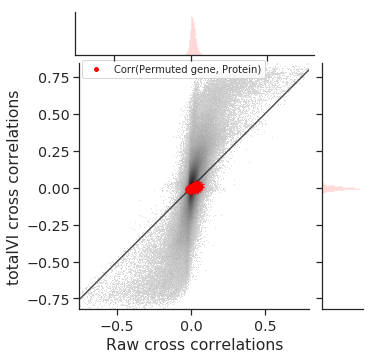

In [23]:
num_pro = dataset.protein_expression.shape[1]

g = sns.jointplot(
    raw_corr[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(), # proteins, permuted genes
    totalVI_corr[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    s=0.05,
    color="red",
    label="Corr(Permuted gene, Protein)",
    zorder=2,
    height=5,
    rasterized=True
)

ax = g.ax_joint

ax.hist2d(
    raw_corr[-num_pro:, :-num_pro].ravel(), # proteins, all genes (including permuted)
    totalVI_corr[-num_pro:, :-num_pro].ravel(),
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=plt.cm.gray_r,
    rasterized=True,
)

legend = ax.legend(loc=4, bbox_to_anchor=(0.83, 0.92), prop={'size': 10}) # 0.85, 0.87

legend.legendHandles[0]._sizes = [15]
# legend.legendHandles[1]._sizes = [15]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot([-1, 1], [-1, 1], "k-", alpha=0.75, zorder=1)
ax.set_aspect("equal")

sns.despine()
ax.set_xlabel("Raw cross correlations")
ax.set_ylabel("totalVI cross correlations")
# g = g.plot_marginals(sns.kdeplot)
# plt.tight_layout()


#g.savefig("figures/good_correlations_spearman.pdf", bbox_inches="tight", dpi = DPI) # plt

Text(8.75, 0.5, 'Naive totalVI cross correlations')

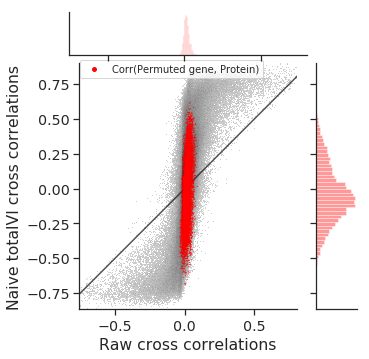

In [24]:
num_pro = dataset.protein_expression.shape[1]

g = sns.jointplot(
    raw_corr[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    totalVI_bad_corr[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    s=0.05,
    color="red",
    label="Corr(Permuted gene, Protein)",
    zorder=2,
    height=5,
    rasterized=True,
)

ax = g.ax_joint

ax.hist2d(
    raw_corr[-num_pro:, :-num_pro].ravel(),
    totalVI_bad_corr[-num_pro:, :-num_pro].ravel(),
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=plt.cm.gray_r,
    rasterized=True,
)

legend = ax.legend(loc=4, bbox_to_anchor=(0.87, 0.92), prop={'size': 10}) # 0.89, 0.87

legend.legendHandles[0]._sizes = [15]
# legend.legendHandles[1]._sizes = [15]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot([-1, 1], [-1, 1], "k-", alpha=0.75, zorder=1)
ax.set_aspect("equal")

sns.despine()
ax.set_xlabel("Raw cross correlations")
ax.set_ylabel("Naive totalVI cross correlations")
# g = g.plot_marginals(sns.kdeplot)
# plt.tight_layout()


#plt.savefig("figures/bad_correlations_spearman.pdf", bbox_inches="tight", dpi = DPI)

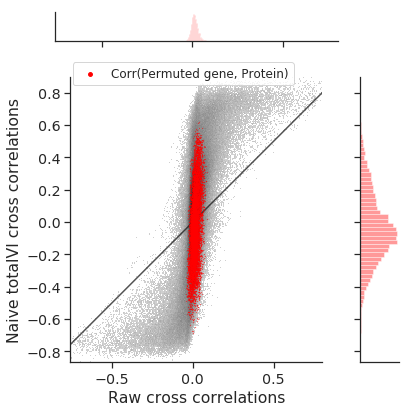

In [36]:
## Plot as PNG

num_pro = dataset.protein_expression.shape[1]

g = sns.jointplot(
    raw_corr[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    totalVI_bad_corr[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    s=0.05,
    color="red",
    label="Corr(Permuted gene, Protein)",
    zorder=2,
    height=6,
    rasterized=True,
)

ax = g.ax_joint

g.ax_joint.hist2d(
    raw_corr[-num_pro:, :-num_pro].ravel(),
    totalVI_bad_corr[-num_pro:, :-num_pro].ravel(),
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=plt.cm.gray_r,
    rasterized=True,
)

legend = ax.legend(loc=4, bbox_to_anchor=(0.91, .95), prop={'size': 12}) # 0.89, 0.87

legend.legendHandles[0]._sizes = [15]
# legend.legendHandles[1]._sizes = [15]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot([-1, 1], [-1, 1], "k-", alpha=0.75, zorder=1)
ax.set_aspect("equal")

sns.despine()
ax.set_xlabel("Raw cross correlations")
ax.set_ylabel("Naive totalVI cross correlations")
# g = g.plot_marginals(sns.kdeplot)
plt.tight_layout()


g.savefig("figures/bad_correlations_spearman_log.png", bbox_inches="tight", dpi = DPI, transparent = True)

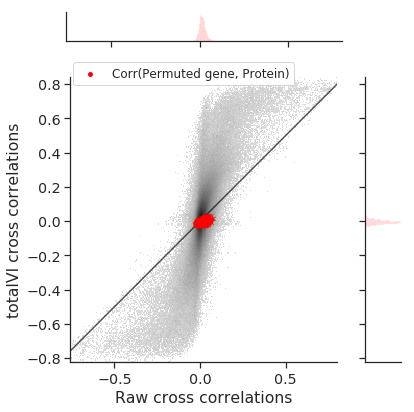

In [38]:
# Plot as PNG

num_pro = dataset.protein_expression.shape[1]

g = sns.jointplot(
    raw_corr[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(), # proteins, permuted genes
    totalVI_corr[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    s=0.05,
    color="red",
    label="Corr(Permuted gene, Protein)",
    zorder=2,
    height=6,
    rasterized=True
)

ax = g.ax_joint

ax.hist2d(
    raw_corr[-num_pro:, :-num_pro].ravel(), # proteins, all genes (including permuted)
    totalVI_corr[-num_pro:, :-num_pro].ravel(),
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=plt.cm.gray_r,
    rasterized=True,
)

legend = ax.legend(loc=4, bbox_to_anchor=(0.86, .95), prop={'size': 12}) # 0.85, 0.87

legend.legendHandles[0]._sizes = [15]
# legend.legendHandles[1]._sizes = [15]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot([-1, 1], [-1, 1], "k-", alpha=0.75, zorder=1)
ax.set_aspect("equal")

sns.despine()
ax.set_xlabel("Raw cross correlations")
ax.set_ylabel("totalVI cross correlations")
# g = g.plot_marginals(sns.kdeplot)
plt.tight_layout()


g.savefig("figures/good_correlations_spearman_log.png", bbox_inches="tight", dpi = DPI, transparent = True) # plt

## Repeat above for Pearson

In [25]:
#totalVI_corr_pearson = full_posterior.generate_feature_correlation_matrix(correlation_mode="pearson", n_samples=2)
totalVI_corr_pearson = full_posterior.generate_feature_correlation_matrix(correlation_mode="pearson", n_samples=2, 
                                                                          log_transform = True,
                                                                         rna_size_factor = 1e4)

In [26]:
denoised_genes, denoised_proteins = full_posterior.get_normalized_denoised_expression(n_samples=25, give_mean=True)
# totalVI_bad_corr = np.corrcoef(np.concatenate([denoised_genes, denoised_proteins], axis=1), rowvar=False)
totalVI_bad_corr_pearson = np.corrcoef(np.concatenate([denoised_genes, denoised_proteins], axis=1), rowvar=False)

In [27]:
same_gene_inds = np.where(anndataset[:, anndataset.var["hvg_encode"]].var["encode"] != "None")[0]

In [30]:
# Raw
#raw_corr_pearson = np.corrcoef(np.concatenate([dataset.X, dataset.protein_expression], axis=1), rowvar=False)

# Raw log normalized
raw_corr_pearson = np.corrcoef(np.concatenate([raw_rna_adata.X, log_protein], axis=1), rowvar = False)

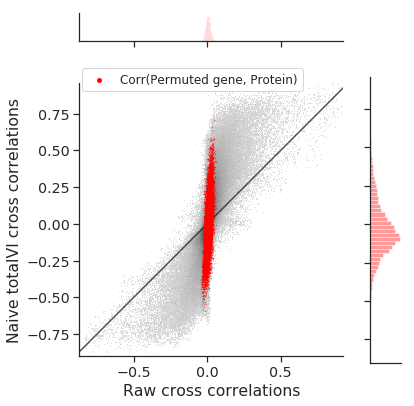

In [43]:
## Plot as PNG

num_pro = dataset.protein_expression.shape[1]

g = sns.jointplot(
    raw_corr_pearson[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    totalVI_bad_corr_pearson[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    s=0.05,
    color="red",
    label="Corr(Permuted gene, Protein)",
    zorder=2,
    height=6,
    rasterized=True,
)

ax = g.ax_joint

g.ax_joint.hist2d(
    raw_corr_pearson[-num_pro:, :-num_pro].ravel(),
    totalVI_bad_corr_pearson[-num_pro:, :-num_pro].ravel(),
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=plt.cm.gray_r,
    rasterized=True,
)

legend = ax.legend(loc=4, bbox_to_anchor=(0.87, .95), prop={'size': 12}) # 0.89, 0.87, (0.98, .95)

legend.legendHandles[0]._sizes = [15]
# legend.legendHandles[1]._sizes = [15]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot([-1, 1], [-1, 1], "k-", alpha=0.75, zorder=1)
ax.set_aspect("equal")

sns.despine()
ax.set_xlabel("Raw cross correlations")
ax.set_ylabel("Naive totalVI cross correlations")
# g = g.plot_marginals(sns.kdeplot)
plt.tight_layout()


g.savefig("figures/bad_correlations_pearson_log.png", bbox_inches="tight", dpi = DPI, transparent = True)

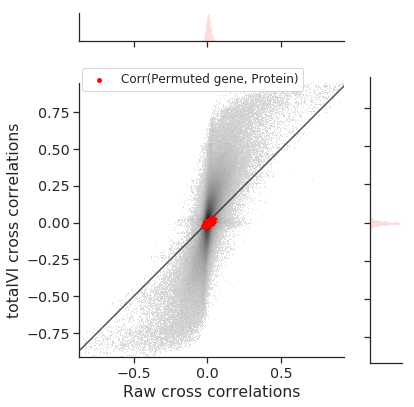

In [45]:
# Plot as PNG

num_pro = dataset.protein_expression.shape[1]

g = sns.jointplot(
    raw_corr_pearson[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(), # proteins, permuted genes
    totalVI_corr_pearson[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    s=0.05,
    color="red",
    label="Corr(Permuted gene, Protein)",
    zorder=2,
    height=6,
    rasterized=True
)

ax = g.ax_joint

ax.hist2d(
    raw_corr_pearson[-num_pro:, :-num_pro].ravel(), # proteins, all genes (including permuted)
    totalVI_corr_pearson[-num_pro:, :-num_pro].ravel(),
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=plt.cm.gray_r,
    rasterized=True,
)

legend = ax.legend(loc=4, bbox_to_anchor=(0.87, .95), prop={'size': 12}) # 0.85, 0.87, (0.85, .95)

legend.legendHandles[0]._sizes = [15]
# legend.legendHandles[1]._sizes = [15]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot([-1, 1], [-1, 1], "k-", alpha=0.75, zorder=1)
ax.set_aspect("equal")

sns.despine()
ax.set_xlabel("Raw cross correlations")
ax.set_ylabel("totalVI cross correlations")
# g = g.plot_marginals(sns.kdeplot)
plt.tight_layout()


g.savefig("figures/good_correlations_pearson_log.png", bbox_inches="tight", dpi = DPI, transparent = True) # plt